In [1]:
# Read modules 
from bs4 import BeautifulSoup
import requests, lxml, os, json
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import date 

## 1. Google scholar 

In [2]:
from parsel import Selector
import requests, re, json

def scrape_all_profiles_from_university(university_name: str):

    # https://docs.python-requests.org/en/master/user/quickstart/#passing-parameters-in-urls
    params = {
        "view_op": "search_authors",  # author results
        "mauthors": university_name,  # search query
        "hl": "en",                   # language
        "astart": 0                   # page number
    }

    # https://docs.python-requests.org/en/master/user/quickstart/#custom-headers
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.87 Safari/537.36",
    }

    profile_results = []

    profiles_is_present = True
    while profiles_is_present:

        html = requests.get("https://scholar.google.com/citations", params=params, headers=headers, timeout=30)
        select = Selector(html.text)

        # print(f"extracting authors at page #{params['astart']}.")

        for profile in select.css(".gs_ai_chpr"):
            name = profile.css(".gs_ai_name a::text").get()
            link = f'https://scholar.google.com{profile.css(".gs_ai_name a::attr(href)").get()}'
            
            affiliations = profile.css(".gs_ai_aff").xpath('normalize-space()').get()
            email = profile.css(".gs_ai_eml::text").get()
            cited_by = re.search(r"\d+", profile.xpath('//div[@class="gs_ai_cby"]').get()).group()  # Cited by 17143 -> 17143
            interests = profile.css(".gs_ai_one_int::text").getall()

            profile_results.append({
                "profile_name": name,
                "profile_link": link,
                "profile_affiliations": affiliations,
                "profile_email": email,
                "profile_city_by_count": cited_by,
                "profile_interests": interests
            })

        # if next page token is present -> update next page token and increment 10 to get the next page
        if select.css("button.gs_btnPR::attr(onclick)").get():
            # https://regex101.com/r/e0mq0C/1
            params["after_author"] = re.search(r"after_author\\x3d(.*)\\x26", select.css("button.gs_btnPR::attr(onclick)").get()).group(1)  # -> XB0HAMS9__8J
            params["astart"] += 10
        else:
            profiles_is_present = False
            
    return profile_results


# print(json.dumps(scrape_all_profiles_from_university(university_name="EM Normandie"), indent=2, ensure_ascii=False))
data = pd.DataFrame(scrape_all_profiles_from_university(university_name="EM Normandie"))
data['author_ID'] = data['profile_link'].apply(lambda x: x.split('=')[-1])
data.drop(['profile_affiliations', 'profile_email', 'profile_city_by_count'],axis =1, inplace = True)
data.head(3)

,profile_name,profile_link,profile_interests,author_ID
0,Ana Beatriz Lopes de Sousa Jabbour,https://scholar.google.com/citations?hl=en&use...,"[Sustainable Supply Chain Management, Circular...",oOmOcaAAAAAJ
1,Christophe Rosenberger,https://scholar.google.com/citations?hl=en&use...,"[Biometrics, Security & Privacy]",TpTmMrkAAAAJ
2,Jean-Christophe Avice,https://scholar.google.com/citations?hl=en&use...,"[Nitrogen and Sulfur Use Efficiency, Nutrients...",TkTj0I4AAAAJ


In [3]:
## Take the names from google scholar 
# import requests, lxml, os

headers = {
    'User-agent':
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.102 Safari/537.36 Edge/18.19582"
}

## get the data for each author 
citations_al = []; citations_sinc = []; h_index_al = []; h_index_sinc= []; i10_index_al = []; i10_index_sinc = []
for link in data['profile_link']:
    html = requests.get(link, headers=headers).text
    soup = BeautifulSoup(html, 'lxml')
    # print(f'Collecting data for: {name}')
    for cited_by_public_access in soup.select('.gsc_rsb'):
        try:
            citations_all = cited_by_public_access.select_one('tr:nth-child(1) .gsc_rsb_sc1+ .gsc_rsb_std').text
        except:
            None  
        try:    
            citations_since = cited_by_public_access.select_one('tr:nth-child(1) .gsc_rsb_std+ .gsc_rsb_std').text
        except:
            None    
        try:
            h_index_all = cited_by_public_access.select_one('tr:nth-child(2) .gsc_rsb_sc1+ .gsc_rsb_std').text
        except:
            None 
        try:
            h_index_since = cited_by_public_access.select_one('tr:nth-child(2) .gsc_rsb_std+ .gsc_rsb_std').text
        except:
            None 
        try: 
            i10_index_all = cited_by_public_access.select_one('tr~ tr+ tr .gsc_rsb_sc1+ .gsc_rsb_std').text
        except: 
            None 
        try: 
            i10_index_since = cited_by_public_access.select_one('tr~ tr+ tr .gsc_rsb_std+ .gsc_rsb_std').text
        except: 
            None 
        # append the output into a list 
        citations_al.append(citations_all)
        citations_sinc.append(citations_since)
        h_index_al.append(h_index_all)
        h_index_sinc.append(h_index_since)
        i10_index_al.append(i10_index_all)
        i10_index_sinc.append(i10_index_since)
    # print(f'{citations_all}\n{citations_since2016}\n{h_index_all}\n{h_index_2016}\n{i10_index_all}\n{i10_index_2016}')
extra_data = pd.DataFrame([citations_al, citations_sinc, h_index_al, h_index_sinc, i10_index_al, i10_index_sinc]).T
extra_data.columns = ['Total citations', 'Citation l 5 yrs', 'Total H-index', "H-index l 5 yrs", "Total i10-index", 'i10-index l 5 yrs']
output = pd.concat([data, extra_data], axis =1)

In [4]:
output.tail(11)

,profile_name,profile_link,profile_interests,author_ID,Total citations,Citation l 5 yrs,Total H-index,H-index l 5 yrs,Total i10-index,i10-index l 5 yrs
58,Mohamed Hachaichi,https://scholar.google.com/citations?hl=en&use...,"[social metabolism, carbon footprint, input ou...",xaceBrYAAAAJ,21,21,2,2,1,1
59,Nicolas Guedeney,https://scholar.google.com/citations?hl=en&use...,"[medicinal chemistry, organic chemistry, vecto...",x-RZHpkAAAAJ,16,16,2,2,1,1
60,Frédéric caumon,https://scholar.google.com/citations?hl=en&use...,[Mathematical Finance],D0slPrsAAAAJ,10,3,1,1,1,0
61,Arnaud DELANNOY,https://scholar.google.com/citations?hl=en&use...,"[Marketing, luxe, marque, comportement du cons...",vg4TNUkAAAAJ,9,6,2,2,0,0
62,Yonathan Silvain Roten,https://scholar.google.com/citations?hl=en&use...,"[Consumer Behavior, Social Psychology, Retaili...",jmQ8r44AAAAJ,8,8,2,2,0,0
63,Linlin Jia (贾林林),https://scholar.google.com/citations?hl=en&use...,"[Graph machine learning , computational …, Gra...",cnlixw0AAAAJ,7,7,2,2,0,0
64,Vincent Meyer,https://scholar.google.com/citations?hl=en&use...,[],iJUWw-EAAAAJ,4,4,1,1,0,0
65,Solène Juteau,https://scholar.google.com/citations?hl=en&use...,[],XmiJS4AAAAAJ,3,3,1,1,0,0
66,Maxime Mauduy,https://scholar.google.com/citations?hl=en&use...,"[Behavior change, Cognitive dissonance, Social...",Db4aA10AAAAJ,2,2,1,1,0,0
67,Aneta Hamza-Orlinska,https://scholar.google.com/citations?hl=en&use...,[Human Resource Management],C6oJtcgAAAAJ,1,1,1,1,0,0


In [5]:
import pandas as pd
from bs4 import BeautifulSoup
import requests, lxml, os

def scrape_all_authors_articles(author_id: str):
    params = {
        "user": author_id,   # user-id
        "hl": "en",          # language
        "gl": "us",          # country to search from
        "cstart": 0,         # articles page. 0 is the first page
        "pagesize": "100"    # articles per page
        }

    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.41 Safari/537.36",
        }

    all_articles = []

    articles_is_present = True
    while articles_is_present:
        html = requests.post("https://scholar.google.com/citations", params=params, headers=headers, timeout=30)
        soup = BeautifulSoup(html.text, "lxml")

        for index, article in enumerate(soup.select("#gsc_a_b .gsc_a_t"), start=1):
            article_title = article.select_one(".gsc_a_at").text
            article_link = f'https://scholar.google.com{article.select_one(".gsc_a_at")["href"]}'
            article_authors = article.select_one(".gsc_a_at+ .gs_gray").text
            article_publication = article.select_one(".gs_gray+ .gs_gray").text

            # print(article_title)

            all_articles.append({
                "title": article_title,
                "link": article_link,
                "authors": article_authors,
                "publication": article_publication
                })

        # this selector is checking for the .class that contains: "There are no articles in this profile."
        # example link: https://scholar.google.com/citations?user=VjJm3zYAAAAJ&hl=en&cstart=500&pagesize=100
        if soup.select_one(".gsc_a_e"):
            articles_is_present = False
        else:
            params["cstart"] += 100  # paginate to the next page

    m = pd.DataFrame(data=all_articles)
    return m

# user_ids = ["rUHfmpQAAAAJ"]

# for _id in user_ids:
#     scrape_all_authors_articles(author_id=_id)

In [6]:
ot = {}

for i in data['author_ID'].tolist():
    s = scrape_all_authors_articles(author_id=i)
    titles = [" - ".join(s['title'])]
    ot[i] = titles
ot = pd.DataFrame(ot).T.reset_index()
ot.columns = ['author_ID', 'Titles']
ot

,author_ID,Titles
0,oOmOcaAAAAAJ,Selecting green suppliers based on GSCM practi...
1,TpTmMrkAAAAJ,Review and evaluation of commonly-implemented ...
2,TkTj0I4AAAAJ,Effect of mineral sulphur availability on nitr...
3,yxk7n1kAAAAJ,Online prediction of time series data with ker...
4,mNELtuMAAAAJ,Corporate governance and voluntary disclosure ...
...,...,...
64,iJUWw-EAAAAJ,Chapitre 6. Les entretiens - Performance manag...
65,XmiJS4AAAAAJ,"Nature, dynamics and coping strategies in the ..."
66,Db4aA10AAAAJ,Why should we ask binge drinkers if they smoke...
67,C6oJtcgAAAAJ,Comment concevoir et déployer une politique Di...


In [7]:
data = pd.merge(data, ot, on = 'author_ID')

In [8]:
data.to_excel('../Output/Dataset.xlsx')

In [10]:
from wordcloud import WordCloud

In [53]:
## clean the coprus 
import nltk
from nltk.corpus import stopwords
print(stopwords.words('french'))

['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'ils', 'je', 'la', 'le', 'les', 'leur', 'lui', 'ma', 'mais', 'me', 'même', 'mes', 'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', 'à', 'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées', 'étés', 'étant', 'étante', 'étants', 'étantes', 'suis', 'es', 'est', 'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 'serons', 'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais', 'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'fût', 'fussions', 'fussiez', 'fussent', 'ayant', 'ayante', 'ayantes', 'ayants', 'eu', 'eue', 'eues', 'eus', 'ai', 'as', 'avons', 'avez', 'ont', 'aurai', 'auras', 'aura', 'aurons', 'aur

In [54]:
from nltk.tokenize import word_tokenize
data['Titles'] = data['Titles'].apply(word_tokenize)

In [58]:
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english') + stopwords.words('french'))
data['Titles']= data['Titles'].apply(lambda x:[word for word in x if word not in stop_words])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mhachaichi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


C:\Users\mhachaichi\AppData\Local\Temp\ipykernel_15304\4222440185.py:9: UserWarning: Glyph 36158 (\N{CJK UNIFIED IDEOGRAPH-8D3E}) missing from current font.
  plt.tight_layout(pad=0)
C:\Users\mhachaichi\AppData\Local\Temp\ipykernel_15304\4222440185.py:9: UserWarning: Glyph 26519 (\N{CJK UNIFIED IDEOGRAPH-6797}) missing from current font.
  plt.tight_layout(pad=0)
C:\Users\mhachaichi\AppData\Local\Temp\ipykernel_15304\4222440185.py:10: UserWarning: Glyph 36158 (\N{CJK UNIFIED IDEOGRAPH-8D3E}) missing from current font.
  plt.savefig(f'../WordCould/{i}.png', dpi = 400, facecolor = 'w')
C:\Users\mhachaichi\AppData\Local\Temp\ipykernel_15304\4222440185.py:10: UserWarning: Glyph 26519 (\N{CJK UNIFIED IDEOGRAPH-6797}) missing from current font.
  plt.savefig(f'../WordCould/{i}.png', dpi = 400, facecolor = 'w')


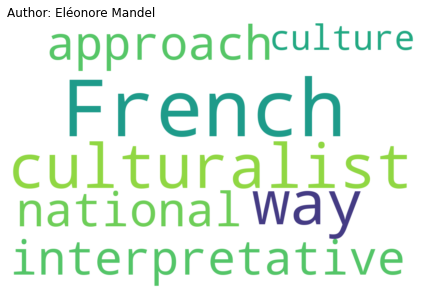

In [67]:
## Display the generated Word Cloud

for i in data['profile_name']:
    d = " ".join(data[data['profile_name'] == i].Titles.iloc[0])
    word_cloud = WordCloud(width=1200, height=800, collocations = False, background_color = 'white').generate(d)
    plt.imshow(word_cloud, interpolation='bilinear', cmap = 'Reds')
    plt.axis("off")
    plt.title(f'Author: {i}', loc = 'left')
    plt.tight_layout(pad=0)
    plt.savefig(f'../WordCould/{i}.png', dpi = 400, facecolor = 'w')
    # plt.show()